# Flood mapping from SAR imagery and validated with Sentinel2

## Loading of the necessaries package

In [1]:
## Loading of the necessaries package
import ee
import geemap
import geemap.chart as chart
import ee.mapclient
import plotly.express as px


import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu, threshold_otsu


---------------------
## Authentification on Google Earth Engine
--------------------------

In [ ]:
# Authenticate
ee.Authenticate()
# initialize
project_name= ???   # Add your project gee project name
ee.Initialize(project=project_name)

--------------------------------------
## Definition of the area of interet for the studie
--------------------------------------


This can be done automatically by drawing the AOI on the map or defined manually the coordinates using geojson.io platform

In [4]:
## First, plot the map   
# Approximate center of West Africa (e.g., near Ghana/Nigeria)
center = [5.0, -2.0]  # Latitude, Longitude   
map=geemap.Map(zoom=7, center=center)
map.add_basemap("HYBRID") #    
map

Map(center=[5.0, -2.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

In [5]:
# Draw your area of interest (AOI) on the map and then execute this cell to take it into account
# You can also add the AOI geometry manually from geojson.io website
# By default the AOI is the Lomé the capital city of Togo

if map.user_roi is not None:
    AOI=map.user_roi
else: # use the default AOI on
    AOI=ee.Geometry.Polygon(
        [[[0.889893, 6.110515],
          [0.889893, 6.342597],
          [1.853943, 6.342597],
          [1.853943, 6.110515],
          [0.889893, 6.110515]]]
         )
# Check the validy of the region of interest  
AOI.getInfo()

{'type': 'Polygon',
 'coordinates': [[[0.889893, 6.110515],
   [1.853943, 6.110515],
   [1.853943, 6.342597],
   [0.889893, 6.342597],
   [0.889893, 6.110515]]]}

### Declaration of constant parameters

In [6]:
event_date = ee.Date('2025-06-02')   # Date de l'événement déclencheur
search= 12                           # interval jour entre debut et fin
start_date = event_date.advance(-search, 'day')
end_date = event_date.advance(search, 'day')

-----------------------------
## SENTINEL-1 : Identifying pre- and post- event imagerie  and Reduction of SAR speckle effect by medium focal smoothing
-----------------------------


### Collect the copernicus SAR IW imagery over the period and location

In [7]:
# Load and preprocess Sentinel-1 SAR image 
def get_s1_images(roi, start_date, end_date):
    """
    roi : region of interest
    start_date
    end_date
    """
    s1_collection = (ee.ImageCollection("COPERNICUS/S1_GRD")
                     .filter(ee.Filter.eq("instrumentMode", "IW"))
                     .filter(ee.Filter.eq("orbitProperties_pass", "ASCENDING"))
                     .filter(ee.Filter.eq("resolution_meters", 10))
                     .filterBounds(roi)
                     .filterDate(start_date, end_date))
    
    if len(s1_collection.getInfo()['features']) < 2:
        raise ValueError("No images found for the event date range and Location." \
                    " Increase the search interval: {search}") 
    else:
        print(f"	Total images available for this regions and period is : {len(s1_collection.getInfo()['features'])} images")
        
    return s1_collection

### Extract first image for pre and post flood event

In [8]:
def pre_and_post_event_images(s1_images, roi, start_date, end_date, event_date, smoothing_radius=50):
    #get the proper post event image
    pre_event_image=s1_images.filterDate(start_date,event_date).sort('system:time_start', False).first()
    post_event_image=s1_images.filterDate(event_date, end_date).first()

    if not pre_event_image or not post_event_image:
        raise ValueError("No images found for the event date range and Location." \
                    " Increase the search interval: {search}") 
    else:
        print(f"    Total images selected for pre event date: {len(s1_images.filterDate(start_date, event_date).getInfo()['features'])} images")
        print(f"    Total images selected for post the event date: {len(s1_images.filterDate(event_date,end_date).getInfo()['features'])} images")

    # Speckle correction
    def speckle_smoothing(image, smoothing_radius = 30):
        kernel = ee.Kernel.square(smoothing_radius, units='meters')
        return image.focal_mean(kernel=kernel, iterations=1)
    
    pre_event_smooth_image=speckle_smoothing(pre_event_image).clip(roi)
    post_event_smooth_image=speckle_smoothing(post_event_image).clip(roi)

    return pre_event_smooth_image, post_event_smooth_image

### Main execution

In [9]:
# Load SAR image collection over the period
S1_collection =get_s1_images(AOI, start_date=start_date, end_date=end_date)

# Load images for pre and post event
SAR_non_flood_img_smooth, SAR_flood_img_smooth=pre_and_post_event_images(S1_collection, roi=AOI, start_date=start_date, end_date=end_date, event_date=event_date)

	Total images available for this regions and period is : 4 images
    Total images selected for pre event date: 2 images
    Total images selected for post the event date: 2 images


-------------------------------
## SENTINEL-2 : Collecting and Identifying pre- and post- event imageries from copernicus Sentinel 2 imagery
-------------------------------


### Extract median image for post and after event

In [10]:
def get_s2_pre_and_post_images(roi, event_date):
    # increase the search value to increase images in
    start_date=event_date.advance(-20, 'day')
    end_date=event_date.advance(20,'day')

    s2_collection= (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))  
          .filterBounds(roi)
          .filterDate(start_date, end_date))

    if len(s2_collection.getInfo()['features']) < 2:
        raise ValueError("No images found for the event date range and Location." \
                    " Increase the search interval: {search}") 
    else:
        print(f"	Total images available for this regions and period is : {len(s2_collection.getInfo()['features'])} images")

    #get the proper post event image
    s2_post_event=s2_collection.filterDate(start_date,event_date).median().clip(roi)
    s2_after_event=s2_collection.filterDate(event_date, end_date).median().clip(roi)
        
    return s2_post_event, s2_after_event


### Compute NDWI from Sentinel-2


In [11]:
def get_ndwi(image):
    green = image.select('B3')
    nir = image.select('B8')
    ndwi = green.subtract(nir).divide(green.add(nir)).rename("NDWI")
    return ndwi

### Main execution

In [ ]:
# Load S2 images for pre and post event
S2_pre_event, S2_post_event=get_s2_pre_and_post_images(AOI, event_date=event_date)

# NDWI mask from Sentinel-2
pre_event_ndwi_mask = get_ndwi(S2_pre_event).gt(0).rename("ndwi_water")
post_event_ndwi_mask = get_ndwi(S2_post_event).gt(0).rename("ndwi_water")

-------------------------------
## Visualization
-------------------------------

In [ ]:
map.addLayer(SAR_non_flood_img_smooth, {'bands':['VH'],'min':-25,'max':0}, 'SAR_non_flood_img_smooth')
map.addLayer(SAR_flood_img_smooth, {'bands':['VH'],'min':-25,'max':0}, 'SAR_flood_img_smooth')
map.addLayer(pre_event_ndwi_mask.updateMask(pre_event_ndwi_mask), {"palette": ["green"]}, "Pre_flood(NDWI)")
map.addLayer(post_event_ndwi_mask.updateMask(post_event_ndwi_mask), {"palette": ["green"]}, "Post_flood (NDWI)")
map.centerObject(SAR_flood_img_smooth)
map

--------------------------------------------
## Identify a threshold to classify land and water for each image
--------------------------------------------------

### Definition of the region of interest that encompense water and raw soil.
Here, draw a polygon, a small area of interest (aoi_hist), in the map viewer to generate an image histogram.
From the histogram, visually identify a threshold value to classify land and water zones.


In [ ]:
if map.user_roi is not None:
    AOI_hist=map.user_roi
else:
    AOI_hist=ee.Geometry.Polygon(
        [[[1.406947563254846,6.279016328141211],
          [1.406947563254846,6.273029988557553],
          [1.4196204943754935,6.273029988557553],
          [1.4196204943754935,6.279016328141211],
          [1.406947563254846,6.279016328141211]
        ]])
    
AOI_hist.getInfo()

### Computing the otsu treshold for histogram or image

In [ ]:
def compute_otsu_threshold(image, band_name, region, scale=30, bins=256, plot=False):
    histogram = image.select(band_name).reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=bins),
        geometry=region,
        scale=scale,
        bestEffort=True
    ).getInfo()[band_name]

    hist = np.array(histogram["histogram"])
    values = np.array(histogram["bucketMeans"])

    # otsu threshold calculation
    probs = hist / np.sum(hist)
    omega = np.cumsum(probs)
    mu = np.cumsum(probs * values)
    mu_t = mu[-1]

    sigma_b_squared = (mu_t * omega - mu) ** 2 / (omega * (1 - omega) + 1e-10)
    max_index = np.argmax(sigma_b_squared)
    threshold = values[max_index]

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(values, hist, label='Histogram')
        plt.axvline(threshold, color='red', linestyle='--', label=f'Otsu Threshold: {threshold:.2f}')
        plt.title(f"Otsu Threshold on {band_name}")
        plt.xlabel('Backscatter (dB)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True)
        plt.show()

    return threshold

### Pre and post threshols estimation

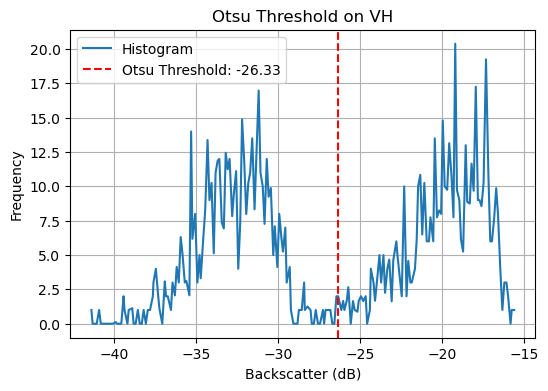

In [16]:
pre_threshold_vh= compute_otsu_threshold(SAR_non_flood_img_smooth, 'VH', AOI_hist, plot=True)

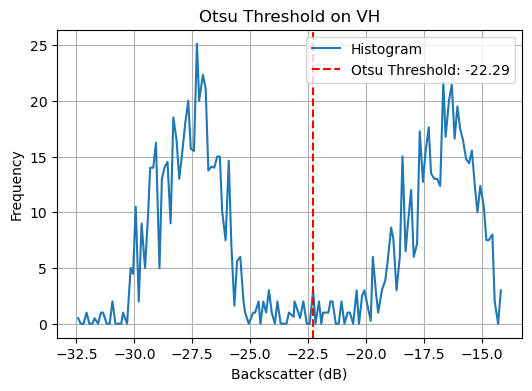

In [17]:
post_threshold_vh= compute_otsu_threshold(SAR_flood_img_smooth, 'VH', AOI_hist, plot=True)

## Otsu threshold method for threshold identification (Second approach)


In [ ]:
def compute_otsu_treshold_and_plot_histogram(image: ee.Image, region: ee.Geometry, scale: int = 10, histogram_bins=256):
    """
    Computes Otsu's threshold on a Google Earth Engine SAR image to distinguish
    water from non-water regions based on backscatter intensity.
    Plots overlaid histograms for VV and VH bands of a SAR image using Plotly Express,
    and overlays the Otsu threshold for the VH band.

    sar_image : ee.Image
        A SAR image (typically in dB) with one band representing backscatter.
    region : ee.Geometry
        The region of interest where the histogram and thresholding are computed.
    scale : int, optional
        The resolution (in meters) to sample the image. Default is 30.
    histogram_bins : int, optional
        Number of bins to use for histogram computation. Default is 256.

    Returns:
    --------
    float
        The computed Otsu threshold value (in the same unit as input image).
    """
    import plotly.express as px
    import plotly.graph_objects as go
    import pandas as pd
    from skimage.filters import threshold_otsu, threshold_multiotsu
    import numpy as np

    # Compute histogram of the image over the region
    histogram = image.reduceRegion(
        reducer=ee.Reducer.histogram(maxBuckets=histogram_bins),
        geometry=region,
        scale=scale,
        bestEffort=True
    ).getInfo()

    # Extract histograms
    vv_hist = histogram['VV']
    vh_hist = histogram['VH']

    # Convert to pandas DataFrame
    df_vv = pd.DataFrame({
        'Backscatter': vv_hist['bucketMeans'],
        'Frequency': vv_hist['histogram'],
        'Band': 'VV'
    })

    df_vh = pd.DataFrame({
        'Backscatter': vh_hist['bucketMeans'],
        'Frequency': vh_hist['histogram'],
        'Band': 'VH'
    })

    # Combine both bands
    df_combined = pd.concat([df_vv, df_vh])

    # Calculate Otsu threshold for VH band only (using bucket means)
    df_vals = np.array(df_combined['Backscatter'])
    df_weights = np.array(df_combined['Frequency'])
    if df_vals.size > 0:
        expanded_df = np.repeat(df_vals, df_weights.astype(int))
        thresh = threshold_otsu(expanded_df)
        print("Otsu Threshold :", thresh)
    else:
        thresh = None
        print(" data is empty; no threshold computed.")

    # Plot using Plotly Graph Objects for custom colors and threshold line
    fig = go.Figure()

    fig.add_trace(go.Bar(
        x=df_vv['Backscatter'], y=df_vv['Frequency'],
        name='VV', marker_color='black', opacity=0.8
    ))

    fig.add_trace(go.Bar(
        x=df_vh['Backscatter'], y=df_vh['Frequency'],
        name='VH', marker_color='blue', opacity=0.8
    ))

    # Add threshold line for VH
    if thresh is not None:
        fig.add_trace(go.Scatter(
            x=[thresh, thresh],
            y=[0, max(df_combined['Frequency'])],
            mode='lines',
            name=f'Otsu VH Threshold ({thresh:.2f})',
            line=dict(color='red', dash='dash', width=2)
        ))

    fig.update_layout(
        title='SAR Histogram - VV and VH Bands (with Otsu Threshold)',
        xaxis_title='Backscatter (dB)',
        yaxis_title='Pixel Count',
        barmode='overlay',
        template='plotly_white'
    )

    fig.show()

In [ ]:
## Plot histogram for SAR_non_flood_smooth
compute_otsu_treshold_and_plot_histogram(SAR_non_flood_img_smooth, AOI_hist)   
## Plot histogram for SAR_non_flood_smooth
compute_otsu_treshold_and_plot_histogram(SAR_flood_img_smooth, AOI_hist)   


------------------------
# Classify the water and land  area from thresholds
----------------
Based on the tresholds previously defined visually from histograms, we can now classify for classes

In [ ]:
#Classify water for pre event image
non_flood_class = SAR_non_flood_img_smooth.select('VH').lt(pre_threshold_vh) # all pixels with value less than -22 will be assigned as 0, otherwise 1

#Classify water for post event image
flood_class = SAR_flood_img_smooth.select('VH').lt(post_threshold_vh) # all pixels with value less than -18.5 will be assigned as 0, otherwise 1

## Calculate the extend of the flood

In [ ]:
# Subtraction of non-flooded image from flooded classified image
flooded_area_SAR = flood_class.subtract(non_flood_class).selfMask()

# Subtraction of non-flooded image from flooded classified image
flooded_area_S2 = post_event_ndwi_mask.subtract(pre_event_ndwi_mask).selfMask()

In [ ]:
#map.addLayer(non_flood_class,{'palette':['gray','blue']}, 'Pre flood class')
#map.addLayer(flood_class,{'palette':['gray','blue']}, 'Post Flood class')
#map.addLayer(flooded_area_SAR,{'palette':['blue']},'flooded_area SAR')
#map.addLayer(flooded_area_S2,{'palette':['yellow']},'flooded_area S2')
#map

--------
## Calculate pixel connectivity to eliminate isolated pixels, e.g. neighbors with less than 8 pixels
--------

In [ ]:
connections = flooded_area_SAR.connectedPixelCount()
flooded_area_conn = flooded_area_SAR.updateMask(connections.gte(8))

------------------------------
## Mask out areas with slopes greater than 5% using a digital elevation model
------------

In [ ]:
DEM = ee.Image('WWF/HydroSHEDS/03VFDEM')
terrain = ee.Algorithms.Terrain(DEM).clip(AOI)
slope = terrain.select('slope')
#Mask out areas with a slope greater than 5% using a digital elevation model.
flooded_area_conn_topo = flooded_area_conn.updateMask(slope.lt(5))

## Visualization

In [ ]:
map.addLayer(flooded_area_SAR,{'palette':['blue']},'flooded_area SAR')
#map.addLayer(flooded_area_conn,{'palette':['yellow']},'flooded_area_conn')
#map.addLayer(terrain.select('hillshade'), {},'hillshade')
map.addLayer(flooded_area_conn_topo,{'palette':['red']},'flooded_area_conn_topo')
map

---------------
# Area Calculation for Water Masks
------------

In [ ]:
def calculate_water_area(mask, region, scale=30):
    """
    Calculates the area (in square kilometers) of the water mask.

    Parameters:
    -----------
    mask : ee.Image
        Binary water mask (1 = water, 0 = non-water).
    region : ee.Geometry
        The region over which to compute the area.
    scale : int
        The scale in meters (e.g., 10 or 30 m for Sentinel).

    Returns:
    --------
    float
        Area in square kilometers.
    """
    pixel_area = ee.Image.pixelArea().divide(1e6)  # m² to km²
    water_area_image = mask.multiply(pixel_area)

    stats = water_area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=scale,
        maxPixels=1e8
    )

    return stats.getInfo()[mask.bandNames().getInfo()[0]]

In [ ]:
water_area_effective = calculate_water_area(flooded_area_conn_topo, AOI)
print("Water Area Estimates (in km²):")
print(f" Effective flooded Area      : {water_area_effective:.2f} km²")

-----
## Export the flood mask map to GEE Assets
------

In [ ]:
# Export the result to google earth engine Assets
task= ee.batch.Export.image.toAsset(
    image= flooded_area_conn_topo,
    description= 'flood_map',
    region= AOI.getInfo()['coordinates'],
    maxPixels= 1e9,
    scale= 10,
    assetId='projects/'your_projectname'/assets/flood_26May2024_Togo',  #
)
task.start()

In [ ]:
task.status()